In [1]:
import json
import numpy as np
import pandas as pd

import sys
sys.path.append('../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

from scipy import spatial

# Devils DFTD Parameter Approximation

This notebook is used to calibrate a initial values which approximately match the results given in Cunningham, Calum X., et al. "Quantifying 25 years of disease‐caused declines in Tasmanian devil populations: host density drives spatial pathogen spread." Ecology Letters 24.5 (2021): 958-969. The objective of this notebook is to gain an "eyeball approximation" of reasonable starting values to serve as input for more sophisticated inferencing.

## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
dates = []
year = 1985
while len(dates) < len(devil_pop):
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

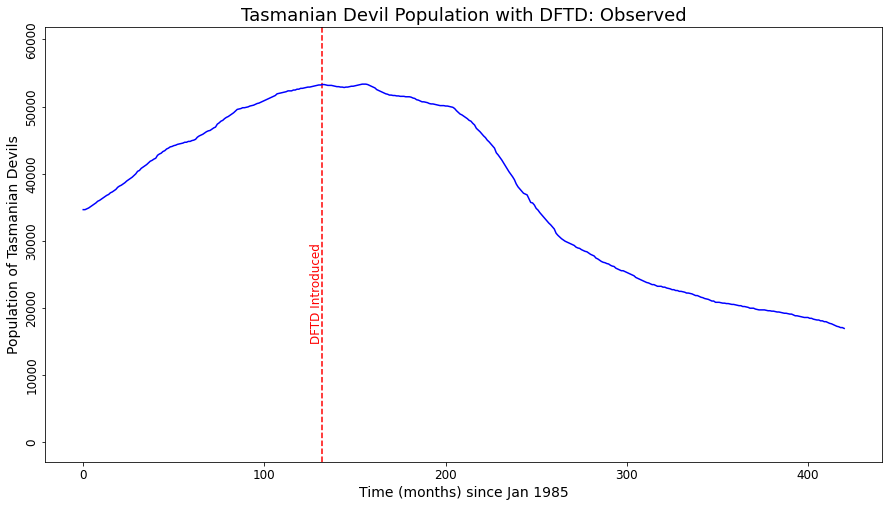

In [3]:
plt.figure(figsize=[15, 8])
plt.title("Tasmanian Devil Population with DFTD: Observed", fontsize=18)
plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
plt.ylabel("Population of Tasmanian Devils", fontsize=14)
plt.plot([132, 132], [-3000, max(devil_pop)*1.16], '--r')
plt.ylim([-3000, max(devil_pop)*1.16])
plt.text(125, 15000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation="vertical", va="center")
_ = plt.plot(range(len(devil_pop)), devil_pop, 'b', label='Observed Total')

## Model

In [4]:
variables = {
    "juvenile_concentration": 0.467,
    "infected_concentration": 5e-5,
    "birth_rate": 0.055,
    "maturity_rate": 0.04267,
    "infection_rate_infected": 2e-05,
    "infection_rate_diseased": 3e-05,
    "incubation": 22.6,
    "progression": 12,
    "death_rate_juvenile": 0.006,
    "death_rate_susceptible": 0.02335,
    "death_rate_over_population": 2.3e-7,
    "death_rate_infected": 0.03,
    "death_rate_diseased": 0.048,
    "DFTD_start": 40
}
variables_orig = variables.copy()

In [5]:
class DevilsPreVaccination(Model):
    def __init__(self, values=variables, events=None):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection")
        self.volume = 1

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression=values['birth_rate'])
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression=values['death_rate_juvenile'])
        maturity_rate = Parameter(name="maturity_rate", expression=values['maturity_rate'])
        death_rate_susceptible = Parameter(
            name="death_rate_susceptible", expression=values['death_rate_susceptible']
        )
        death_rate_over_population = Parameter(
            name="death_rate_over_population", expression=values['death_rate_over_population']
        )
        infection_rate_infected = Parameter(
            name="infection_rate_infected", expression=values['infection_rate_infected']
        )
        infection_rate_diseased = Parameter(
            name="infection_rate_diseased", expression=values['infection_rate_diseased']
        )
        incubation = Parameter(name="incubation", expression=values['incubation'])
        death_rate_infected = Parameter(name="death_rate_infected", expression=values['death_rate_infected'])
        progression = Parameter(name="progression", expression=values['progression'])
        death_rate_diseased = Parameter(name="death_rate_diseased", expression=values['death_rate_diseased'])
        DFTD_start = Parameter(name="DFTD_start", expression=values['DFTD_start'])
        self.add_parameter([birth_rate, death_rate_juvenile, maturity_rate, death_rate_susceptible,
                            death_rate_over_population, infection_rate_infected, infection_rate_diseased,
                            incubation, death_rate_infected, progression, death_rate_diseased, DFTD_start])

        # Variables (initial values adjusted to observed data)
        initial_devil_population  = int(devil_pop[0])
        
        Juvenile = Species(
            name="Juvenile", mode="discrete",
            initial_value=round(initial_devil_population * values['juvenile_concentration'])
        )
        Susceptible = Species(
            name="Susceptible", mode="discrete",
            initial_value=round(initial_devil_population * (1 - values['juvenile_concentration']))
        )
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Devils = Species(name="Devils", initial_value=initial_devil_population, mode="discrete")
        self.add_species([Juvenile, Susceptible, Exposed, Infected, Diseased, Devils])

        # Reactions
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        self.add_reaction([Birth, Mature])
        
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        self.add_reaction([Death_Juvenile, Death_Susceptible, Death_Exposed, Death_Infected, Death_Diseased,
                           Death_Juvenile2, Death_Susceptible2, Death_Exposed2, Death_Infected2, Death_Diseased2])
        
        
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected':1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased':1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        self.add_reaction([TransmissionI, TransmissionD, DFTD_Stage1, DFTD_Stage2])

        # Events
        if events is not None:
            self.add_event(events)

        # Timespan
        self.timespan(np.arange(0, 421, 1)) # month data tspan
        
    def run(self, with_pr=False, **kwargs):
        if not with_pr:
            return super().run(**kwargs)
        
        self.resolve_parameters()
        t = int(self.listOfParameters['DFTD_start'].value)
        res1 = super().run(**kwargs, t=t)
        
        if not "variables" in kwargs.keys():
            kwargs['variables'] = {}
        kwargs['variables']['Infected'] = "1"
        kwargs['variables']['Susceptible'] = f"{int(res1[0]['Susceptible'][-1] - 1)}"
        
        res2 = super().run(resume=res1, **kwargs)
        for species in self.listOfSpecies.keys():
            res2[0][species] = res2[0][species][:-1]
        
        return res2

## Carrying Capacity Mechanics

Number of Devils 61211.0 at simulation end, 98.9% of target carrying capacity


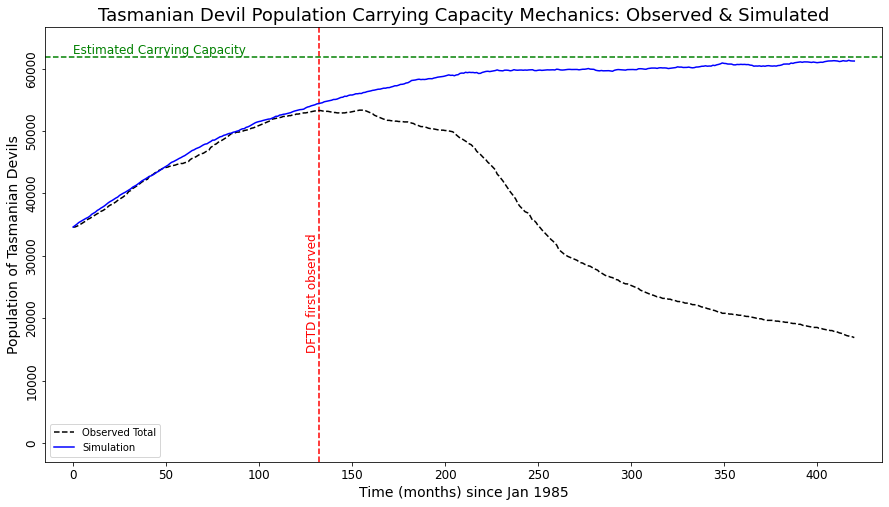

In [6]:
carry_cap = int(max(devil_pop)*1.16)

model = DevilsPreVaccination()
result = model.run(solver=SSACSolver)

plt.figure(figsize=[15, 8])
plt.title("Tasmanian Devil Population Carrying Capacity Mechanics: Observed & Simulated", fontsize=18)
plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
plt.ylabel("Population of Tasmanian Devils", fontsize=14)
plt.plot([132, 132], [-3000, max(devil_pop)*1.25], '--r')
plt.plot([-15, result['time'][-1] + 15], [carry_cap, carry_cap], '--g')
plt.xlim([-15, result['time'][-1] + 15])
plt.ylim([-3000, max(devil_pop)*1.25])
plt.text(0, carry_cap + 500, "Estimated Carrying Capacity", color="green", fontsize=12)
plt.text(125, 15000, "DFTD first observed", rotation="vertical", color="red", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation="vertical", va="center")
plt.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed Total')
plt.plot(result[0]['Devils'],'b', label="Simulation")
_ = plt.legend(loc='best')

final_devil_pop = result[0]['Devils'][-1]

print(f"Number of Devils {final_devil_pop} at simulation end,",
      f"{final_devil_pop/carry_cap*100:.1f}% of target carrying capacity")

In [7]:
def event_model(run=False):
    carry_cap = int(max(devil_pop)*1.16)
    
    trigger = EventTrigger(expression=f"t >= {variables['DFTD_start']}")
    assignments = [
        EventAssignment(
            variable="Infected", 
            expression=f"round(Susceptible * {variables['infected_concentration']})"
        ),
        EventAssignment(
            variable="Susceptible", 
            expression=f"round(Susceptible * 1-{variables['infected_concentration']})"
        )
    ]
    DFTD_Introduction = Event(name="DFTD_Introduction", assignments=assignments, trigger=trigger)
    
    e_model = DevilsPreVaccination(values=variables, events=[DFTD_Introduction])
    
    if not run:
        return e_model
    
    results = e_model.run()

    plt.figure(figsize=[15, 8])
    plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
    plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
    plt.ylabel("Population of Tasmanian Devils", fontsize=14)
    plt.plot(results['time'], obs[0][0], '--', color='black', label='Observed Total')
    plt.plot(results['time'], results['Devils'], color='blue', label='Simulated Total')
    plt.plot(results['time'], results['Juvenile'], color='purple', alpha=.3, label='Juvenile')
    plt.plot(results['time'], results['Susceptible'], color='green', alpha=.3, label='Susceptible')
    plt.plot(results['time'], results['Exposed'], color='magenta', alpha=.3, label='Exposed')
    plt.plot(results['time'], results['Infected'], color='red', alpha=.3, label='Infected')
    plt.plot(results['time'], results['Diseased'], color='cyan', alpha=.3, label='Diseased')
    plt.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--r')
    plt.ylim([-3000, carry_cap])
    plt.text(variables['DFTD_start']-7, 15000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation="vertical", va="center")
    plt.legend(loc='best', fontsize=12)

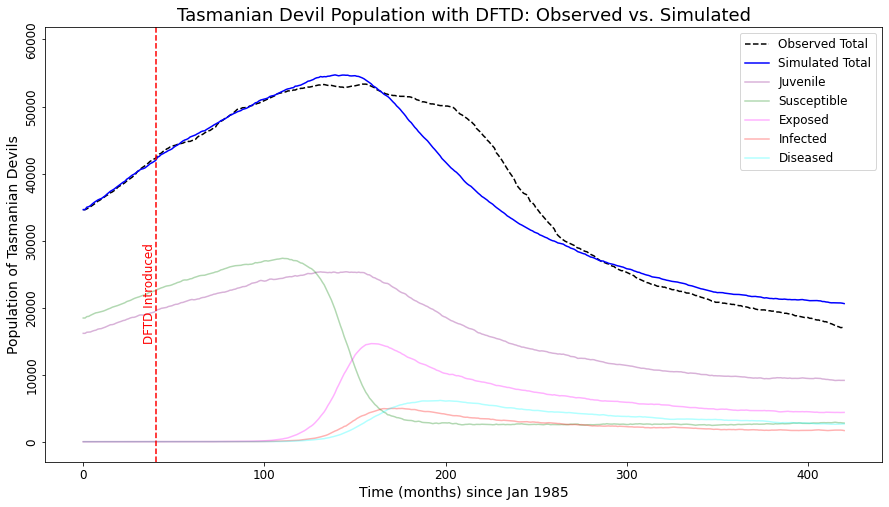

In [8]:
event_model(run=True)

In [9]:
model = DevilsPreVaccination(values=variables)

In [10]:
solver = SSACSolver(model, variable=True)

## Configure Solver Widgets

In [22]:
def run_pre_infection(start, end):
    variable = {
        "Devils": round(devil_pop[start]),
        "Juvenile": round(devil_pop[start] * variables['juvenile_concentration']),
        "Susceptible": round(devil_pop[start] * (1 - variables['juvenile_concentration'])),
        "birth_rate": variables['birth_rate'],
        "maturity_rate": variables['maturity_rate'],
        "death_rate_juvenile": variables['death_rate_juvenile'],
        "death_rate_susceptible": variables['death_rate_susceptible'],
        "death_rate_over_population": variables['death_rate_over_population']
    }
    
    results = solver.run(model=model, variables=variable, t=end-start)
    total_devils = np.add(np.add(
        np.add(results['Juvenile'], results['Susceptible']), np.add(results['Exposed'], results['Infected'])
    ), results['Diseased'])
    ec_result = spatial.distance.euclidean(total_devils, devil_pop[start:end+1])
    mn_result = spatial.distance.cityblock(total_devils, devil_pop[start:end+1])
    return (results, total_devils, ec_result, mn_result)

In [23]:
def run_post_infection(start, end, pre_result, DFTD_start):
    if start == (DFTD_start + 1):
        kwargs = {"t": end-start+len(pre_result['time']), "resume": pre_result}
        Devils_pop = pre_result['Devils'][-1]
        init_S_pop = pre_result['Susceptible'][-1]
        J_pop = pre_result['Juvenile'][-1]
        I_pop = max(round(init_S_pop * variables['infected_concentration']), 1) # must have at least 1
        S_pop = init_S_pop - I_pop
    else:
        kwargs = {"t": end-start}
        Devils_pop = round(devil_pop[start])
        J_pop = round(devil_pop[start] * variables['juvenile_concentration'])
        init_S_pop = devil_pop[start] - J_pop
        I_pop = max(round(init_S_pop * variables['infected_concentration']), 1) # must have at least 1
        S_pop = init_S_pop - I_pop
    
    variable = {
        "Devils": Devils_pop,
        "Juvenile": J_pop,
        "Susceptible": S_pop,
        "Infected": I_pop,
        "birth_rate": variables['birth_rate'],
        "maturity_rate": variables['maturity_rate'],
        "infection_rate_infected": variables['infection_rate_infected'],
        "infection_rate_diseased": variables['infection_rate_diseased'],
        "incubation": variables['incubation'],
        "progression": variables['progression'],
        "death_rate_juvenile": variables['death_rate_juvenile'],
        "death_rate_susceptible": variables['death_rate_susceptible'],
        "death_rate_over_population": variables['death_rate_over_population'],
        "death_rate_infected": variables['death_rate_infected'],
        "death_rate_diseased": variables['death_rate_diseased']
    }
    
    results = solver.run(model=model, variables=variable, **kwargs)
    total_devils = np.add(np.add(
        np.add(results['Juvenile'], results['Susceptible']), np.add(results['Exposed'], results['Infected'])
    ), results['Diseased'])
    ec_result = spatial.distance.euclidean(total_devils, devil_pop)
    mn_result = spatial.distance.cityblock(total_devils, devil_pop)
    return (results, total_devils, ec_result, mn_result)

In [25]:
def display_solver_args():
    width = 112
    d_width = width - 4
    h_width = int(d_width/2)
    pad = "    "
    pnt_els = ['='*width]
    
    # Changes to species concentration values
    pnt_els.append(" ".join(['|', 'Input Species:'.ljust(d_width), '|']))
    sc_line = f'{pad}Juvenile Concentration: {variables["juvenile_concentration"]}'
    if variables["juvenile_concentration"] != variables_orig["juvenile_concentration"]:
        sc_line += f'{pad}(was {variables_orig["juvenile_concentration"]})'
    sc_line = sc_line.ljust(h_width)
    sc_line += f'{pad}Infected Concentration: {variables["infected_concentration"]}'
    if variables["infected_concentration"] != variables_orig["infected_concentration"]:
        sc_line += f'{pad}(was {variables_orig["infected_concentration"]})'
    pnt_els.append(" ".join(['|', sc_line.ljust(d_width), '|']))
    pnt_els.append(f'| {"-"*d_width} |')
    
    # Changes to parameters
    pnt_els.append(" ".join(['|', 'Input Parameters:'.ljust(d_width), '|']))
    bm_line = f'{pad}Birth Rate: {variables["birth_rate"]}'
    if variables["birth_rate"] != variables_orig["birth_rate"]:
        bm_line += f'{pad}(was {variables_orig["birth_rate"]})'
    bm_line = bm_line.ljust(h_width)
    bm_line += f'{pad}Maturity Rate: {variables["maturity_rate"]}'
    if variables["maturity_rate"] != variables_orig["maturity_rate"]:
        bm_line += f'{pad}(was {variables_orig["maturity_rate"]})'
    pnt_els.append(" ".join(['|', bm_line.ljust(d_width), '|']))
    
    ir_line = f'{pad}Infection Rate Infected: {variables["infection_rate_infected"]}'
    if variables["infection_rate_infected"] != variables_orig["infection_rate_infected"]:
        ir_line += f'{pad}(was {variables_orig["infection_rate_infected"]})'
    ir_line = ir_line.ljust(h_width)
    ir_line += f'{pad}Infection Rate Diseased: {variables["infection_rate_diseased"]}'
    if variables["infection_rate_diseased"] != variables_orig["infection_rate_diseased"]:
        ir_line += f'{pad}(was {variables_orig["infection_rate_diseased"]})'
    pnt_els.append(" ".join(['|', ir_line.ljust(d_width), '|']))
    
    ip_line = f'{pad}Incubation: {variables["incubation"]}'
    if variables["incubation"] != variables_orig["incubation"]:
        ip_line += f'{pad}(was {variables_orig["incubation"]})'
    ip_line = ip_line.ljust(h_width)
    ip_line += f'{pad}Progression: {variables["progression"]}'
    if variables["progression"] != variables_orig["progression"]:
        ip_line += f'{pad}(was {variables_orig["progression"]})'
    pnt_els.append(" ".join(['|', ip_line.ljust(d_width), '|']))
    
    jsd_line = f'{pad}Death Rate Juvenile: {variables["death_rate_juvenile"]}'
    if variables["death_rate_juvenile"] != variables_orig["death_rate_juvenile"]:
        jsd_line += f'{pad}(was {variables_orig["death_rate_juvenile"]})'
    jsd_line = jsd_line.ljust(h_width)
    jsd_line += f'{pad}Death Rate Susceptible: {variables["death_rate_susceptible"]}'
    if variables["death_rate_susceptible"] != variables_orig["death_rate_susceptible"]:
        jsd_line += f'{pad}(was {variables_orig["death_rate_susceptible"]})'
    pnt_els.append(" ".join(['|', jsd_line.ljust(d_width), '|']))
    
    idd_line = f'{pad}Death Rate Infected: {variables["death_rate_infected"]}'
    if variables["death_rate_infected"] != variables_orig["death_rate_infected"]:
        idd_line += f'{pad}(was {variables_orig["death_rate_infected"]})'
    idd_line = idd_line.ljust(h_width)
    idd_line += f'{pad}Death Rate Diseased: {variables["death_rate_diseased"]}'
    if variables["death_rate_diseased"] != variables_orig["death_rate_diseased"]:
        idd_line += f'{pad}(was {variables_orig["death_rate_diseased"]})'
    pnt_els.append(" ".join(['|', idd_line.ljust(d_width), '|']))
    
    opd_line = f'{pad}Death Rate Over Population: {variables["death_rate_over_population"]}'
    if variables["death_rate_over_population"] != variables_orig["death_rate_over_population"]:
        opd_line += f'{pad}(was {variables_orig["death_rate_over_population"]})'
    pnt_els.append(" ".join(['|', opd_line.ljust(d_width), '|']))
    pnt_els.append(f'|{"="*(width-2)}|')
    
    print("\n".join(pnt_els))

In [26]:
def display_details(pre_start, pre_end, post_start, post_end, pre_data, post_data):
    width = 112
    s_width = int(width / 2)
    sd_width = s_width - 4
    pad = "    "
    pnt_els = []
    
    # Pre-Infection Simulation Details
    sec_lines = [" ".join(['|', 'Pre-Infection'.ljust(sd_width), '|'])]
    sec_lines.append(" ".join(['|', f'{pad}Time Range: {dates[pre_start]} - {dates[pre_end]}'.ljust(sd_width), '|']))
    init_dev_pop = round(devil_pop[pre_start])
    sec_lines.append(" ".join(['|', f'{pad}Initial Value of Devils: {init_dev_pop}'.ljust(sd_width), '|']))
    init_juv_pop = round(devil_pop[pre_start] * variables['juvenile_concentration'])
    sec_lines.append(" ".join(['|', f'{pad}Initial Value of Juvenile: {init_juv_pop}'.ljust(sd_width), '|']))
    init_sus_pop = round(devil_pop[pre_start] * (1 - variables['juvenile_concentration']))
    sec_lines.append(" ".join(['|', f'{pad}Initial Value of Susceptible: {init_sus_pop}'.ljust(sd_width), '|']))
    sec_lines.append(f'| {" "*sd_width} |')
    sec_lines.append(" ".join(['|', f'{pad}Distance Metrics:'.ljust(sd_width), 
                               '||', f'{pad}Distance Metrics:'.ljust(sd_width), '|']))
    sec_lines.append(" ".join(['|', f'{pad*2}Euclidean: {pre_data[2]}'.ljust(sd_width), '|']))
    sec_lines.append(" ".join(['|', f'{pad*2}Manhattan: {pre_data[3]}'.ljust(sd_width), '|']))
    sec_lines.append(
        " ".join(['|', f'{pad}TOTAL Expected: {devil_pop[pre_end-1]} - Got: {pre_data[1][-1]}'.ljust(sd_width), '|'])
    )
    
    # Post-Infection Simulation Details
    sec_lines[0] += " ".join(['|', 'Post-Infection'.ljust(sd_width), '|'])
    sec_lines[1] += " ".join(['|', f'{pad}Time Range: {dates[post_start]} - {dates[post_end]}'.ljust(sd_width), '|'])
    init_dev_pop = round(devil_pop[post_start])
    sec_lines[2] += " ".join(['|', f'{pad}Initial Value of Devils: {init_dev_pop}'.ljust(sd_width), '|'])
    init_juv_pop = post_data[0]["Juvenile"][0]
    sec_lines[3] += " ".join(['|', f'{pad}Initial Value of Juvenile: {init_juv_pop}'.ljust(sd_width), '|'])
    init_sus_pop = post_data[0]["Susceptible"][0]
    sec_lines[4] += " ".join(['|', f'{pad}Initial Value of Susceptible: {init_sus_pop}'.ljust(sd_width), '|'])
    init_inf_pop = post_data[0]["Infected"][post_start]
    sec_lines[5] += " ".join(['|', f'{pad}Initial Value of Infected: {init_inf_pop}'.ljust(sd_width), '|'])
    sec_lines[7] += " ".join(['|', f'{pad*2}Euclidean: {post_data[2]}'.ljust(sd_width), '|'])
    sec_lines[8] += " ".join(['|', f'{pad*2}Manhattan: {post_data[3]}'.ljust(sd_width), '|'])
    sec_lines[9] += " ".join(['|', f'{pad}TOTAL Expected: {devil_pop[post_end-1]} - Got: {post_data[1][-1]}'.ljust(sd_width), '|'])
    pnt_els.extend(sec_lines)
    pnt_els.append('='*width)
    
    print("\n".join(pnt_els))

In [27]:
def plot(pre_start, pre_end, post_start, post_end, pre_data, post_data, DFTD_start):
    carry_cap = int(max(devil_pop)*1.16)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])
    
    ax1.plot(range(pre_start, pre_end), devil_pop[pre_start:pre_end], '--', color='black', label='Observed Total')
    ax1.plot(range(pre_start, pre_end+1), pre_data[1], color='blue', label='Simulated Total')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Juvenile'], color='purple', alpha=.3, label='Juvenile')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Susceptible'], color='green', alpha=.3, label='Susceptible')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Infected'], color='red', alpha=.3, label='Infected')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Exposed'], color='magenta', alpha=.3, label='Exposed')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['Diseased'], color='cyan', alpha=.3, label='Diseased')
    ax1.set_ylim(top=carry_cap)
    ax1.set_xlabel(f"Time (months) since {dates[pre_start]}", fontsize=14)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)
    ax1.tick_params(axis="x", labelsize=12)
    ax1.tick_params(axis="y", labelsize=12, labelrotation=90)
    ax1.legend(loc='best')
    ax1.set_title(f'Tasmanian Devil Population: {dates[pre_start]}-{dates[pre_end]}', fontsize=14)
    
    if post_start > (DFTD_start + 1):
        x = range(post_start, post_end+1)
        obs_devils = devil_pop[post_start:post_end]
        sim_devils = post_data[1]
        Juvenile = post_data[0]['Juvenile']
        Susceptible = post_data[0]['Susceptible']
        Infected = post_data[0]['Infected']
        Exposed = post_data[0]['Exposed']
        Diseased = post_data[0]['Diseased']
    else:
        x = range(pre_end, post_end+1)
        obs_devils = devil_pop[pre_end:post_end]
        sim_devils = post_data[1][pre_end:post_end+1]
        Juvenile = post_data[0]['Juvenile'][pre_end:post_end+1]
        Susceptible = post_data[0]['Susceptible'][pre_end:post_end+1]
        Infected = post_data[0]['Infected'][pre_end:post_end+1]
        Exposed = post_data[0]['Exposed'][pre_end:post_end+1]
        Diseased = post_data[0]['Diseased'][pre_end:post_end+1]
    ax2.plot(x[:-1], obs_devils, '--', color='black', label='Observed Total')
    ax2.plot(x, sim_devils, color='blue', label='Simulated Total')
    ax2.plot(x, Juvenile, color='purple', alpha=.3, label='Juvenile')
    ax2.plot(x, Susceptible, color='green', alpha=.3, label='Susceptible')
    ax2.plot(x, Infected, color='red', alpha=.3, label='Infected')
    ax2.plot(x, Exposed, color='magenta', alpha=.3, label='Exposed')
    ax2.plot(x, Diseased, color='cyan', alpha=.3, label='Diseased')
    ax2.set_ylim(top=carry_cap)
    ax2.set_xlabel(f"Time (months) since {dates[post_start]}", fontsize=14)
    ax2.set_ylabel("Population of Tasmanian Devils", fontsize=14)
    ax2.tick_params(axis="x", labelsize=12)
    ax2.tick_params(axis="y", labelsize=12, labelrotation=90)
    ax2.legend(loc='best')
    ax2.set_title(f'Tasmanian Devil Population with DFTD: {dates[post_start]}-{dates[post_end]}', fontsize=14)

In [28]:
def configure(start, end, DFTD_start, juvenile_concentration, birth_rate,  maturity_rate,
              death_rate_juvenile, death_rate_susceptible, death_rate_over_population, infected_concentration,
              infection_rate_infected, infection_rate_diseased, incubation, death_rate_infected, progression,
              death_rate_diseased):
    pre_start = 0 if start >= DFTD_start else start
    pre_end = DFTD_start if end > DFTD_start else end
    post_start = (DFTD_start + 1) if start < (DFTD_start + 1) else start
    post_end = 420 if end <= DFTD_start else end

    run_pre = False
    try:
        pre_data
        if start < (DFTD_start + 1):
            if (pre_end - pre_start) != len(pre_data[0]['time']):
                run_pre = True
            else:
                run_pre = variables['juvenile_concentration'] != juvenile_concentration or \
                variables['birth'] != birth_rate or \
                variables['maturity_rate'] != maturity_rate or \
                variables['death_rate_juvenile'] != death_rate_juvenile or \
                variables['death_rate_susceptible'] != death_rate_susceptible or \
                variables['death_rate_over_population'] != death_rate_over_population
    except:
        run_pre = True
        
    try:
        post_data
        run_post = end > 132
    except:
        run_post = True
    
    variables['DFTD_start'] = DFTD_start
    variables['juvenile_concentration'] = juvenile_concentration
    variables['infected_concentration'] = infected_concentration
    variables['birth_rate'] = birth_rate
    variables['maturity_rate'] = maturity_rate
    variables['infection_rate_infected'] = infection_rate_infected
    variables['infection_rate_diseased'] = infection_rate_diseased
    variables['incubation'] = incubation
    variables['progression'] = progression
    variables['death_rate_juvenile'] = death_rate_juvenile
    variables['death_rate_susceptible'] = death_rate_susceptible
    variables['death_rate_over_population'] = death_rate_over_population
    variables['death_rate_infected'] = death_rate_infected
    variables['death_rate_diseased'] = death_rate_diseased
    
    display_solver_args()
    
    if run_pre:
        pre_data = run_pre_infection(pre_start, pre_end)
        
    if run_post:
        post_data = run_post_infection(post_start, post_end, pre_data[0], DFTD_start)
        
    plot(pre_start, pre_end, post_start, post_end, pre_data, post_data, DFTD_start)
    
    display_details(pre_start, pre_end, post_start, post_end, pre_data, post_data)

## Create Widgets

In [29]:
for k,v in variables_orig.items():
    print(f'{k.ljust(30)}: {v}')

juvenile_concentration        : 0.467
infected_concentration        : 5e-05
birth_rate                    : 0.055
maturity_rate                 : 0.04267
infection_rate_infected       : 2e-05
infection_rate_diseased       : 3e-05
incubation                    : 22.6
progression                   : 12
death_rate_juvenile           : 0.006
death_rate_susceptible        : 0.02335
death_rate_over_population    : 2.3e-07
death_rate_infected           : 0.03
death_rate_diseased           : 0.048
DFTD_start                    : 40


In [30]:
s1 = widgets.IntSlider(
    min=0, max=419, step=1, value=0, description="Start"
)
s2 = widgets.IntSlider(
    min=1, max=420, step=1, value=420, description="End"
)
s3 = widgets.IntSlider(
    min=1, max=419, step=1, value=variables['DFTD_start'], description="DFTD Start"
)
s4 = widgets.FloatSlider(
    min=0.001, max=1, step=0.001, value=variables['juvenile_concentration'], description="Juv. Concen."
)
s5 = widgets.FloatSlider(
    min=1e-6, max=1, step=1e-6, value=variables['infected_concentration'], description="Inf. Concen."
)
s6 = widgets.FloatSlider(
    min=0.001, max=0.1, step=0.001, value=variables['birth_rate'], description="Birth Rate"
)
s7 = widgets.FloatSlider(
    min=1e-5, max=0.1, step=1e-5, value=variables['maturity_rate'], description="Maturity Rate"
)
s8 = widgets.FloatSlider(
    min=0, max=100, step=0.01, value=variables['incubation'], description="Incubation"
)
s9 = widgets.FloatSlider(
    min=1e-6, max=0.001, step=1e-6, value=variables['infection_rate_infected'], description="Infect Rate I"
)
s10 = widgets.FloatSlider(
    min=0.001, max=0.1, step=0.001, value=variables['death_rate_juvenile'], description="Death R. Juv."
)
s11 = widgets.FloatSlider(
    min=1e-5, max=0.1, step=1e-5, value=variables['death_rate_susceptible'], description="Death R. Sus."
)
s12 = widgets.FloatSlider(
    min=0.001, max=0.1, step=.001, value=variables['death_rate_infected'], description="Death R. Inf."
)
s13 = widgets.FloatSlider(
    min=1e-9, max=1e-5, step=1e-9, value=variables['death_rate_over_population'], description="Death R. All"
)
s14 = widgets.FloatSlider(
    min=0, max=100, step=1, value=variables['progression'], description="Progression"
)
s15 = widgets.FloatSlider(
    min=0, max=1, step=.001, value=variables['death_rate_diseased'], description="Death R. Dis."
)
s16 = widgets.FloatSlider(
    min=1e-7, max=0.0001, step=1e-7, value=variables['infection_rate_diseased'], description="Infect Rate D"
)

ai_widgets = {'start': s1, 'end': s2, 'DFTD_start': s3,
              'juvenile_concentration': s4, 'infected_concentration': s5,
              'birth_rate': s6, 'maturity_rate': s7, 'incubation': s8, 
              'infection_rate_infected': s9, 'death_rate_juvenile': s10,
              'death_rate_susceptible': s11, 'death_rate_infected': s12,
              'death_rate_over_population': s13, 'progression': s14,
              'death_rate_diseased': s15, 'infection_rate_diseased': s16
             }

In [31]:
def get_layout(vertical=False):
    kwargs = {
        "margin": '0px 10px 10px 0px',
        "padding": '5px 5px 5px 5px'
    }
    if not vertical:
        kwargs['border'] = 'solid 1px red'
    return widgets.Layout(**kwargs)

hb1 = widgets.HBox([s1, s2, s3], layout=get_layout())
hb2 = widgets.HBox([
    widgets.VBox([s4, s10], layout=get_layout(vertical=True)),
    widgets.VBox([s6, s11], layout=get_layout(vertical=True)),
    widgets.VBox([s7, s13], layout=get_layout(vertical=True))
], layout=get_layout())
hb3 = widgets.HBox([
    widgets.VBox([s9, s5, s14], layout=get_layout(vertical=True)),
    widgets.VBox([s16, s12, s15], layout=get_layout(vertical=True)),
    widgets.VBox([s8], layout=get_layout(vertical=True))
], layout=get_layout())

ui = widgets.VBox([hb1, hb2, hb3])

## Run widgets and attempt to calibrate model

In [32]:
out = interactive_output(configure, ai_widgets)
display(out, ui)

Output()

## Run calibrated event model

In [ ]:
event_model(run=True)

## Export model as StochSS Model (.mdl)

In [ ]:
# model = event_model()
# stochss_mdl = export_StochSS(model, return_stochss_model=True)
# stochss_mdl['name'] = model.name
# class NumpyEncoder(json.JSONEncoder):
#     def default(self, o):
#         if isinstance(o, np.ndarray):
#             return o.tolist()
#         if isinstance(o, np.int64):
#             return int(o)
#         return json.JSONEncoder.default(self, o)
# with open(f"{model.name}.mdl", "w") as mdl_file:
#     json.dump(stochss_mdl, mdl_file, indent=4, sort_keys=True, cls=NumpyEncoder)